In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [ ]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

def execute_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)
    generator_conf = conf.get("generator_conf", {})

    transition_conf = conf.get("transition_conf", {})
    if "model_dir" in transition_conf:
        transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
        lang_path = add_sep(transition_conf["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_conf)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_conf", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_conf", {}))
        generator_conf["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang, device=conf.get("device")) # TODO: change after root node generalization
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **generator_conf)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)

    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_conf", {}))
    generator.analyze()
    
    return generator, conf

def queue_yaml(*args: str):
    for yaml_path in args:
        execute_yaml(yaml_path)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is CUDA available: False
Starting generation...
1- time: 0.00, reward: 0.46267535191117953, node: C(C)c1nc(C[S@@](=O)Cc2cn(-c3ccccc3)nc2-c2ccccc2)cs1
2- time: 0.10, reward: 0.32952027632635367, node: CN(Cc1nnc(-c2ccncc2)o1)C(=O)C[C@@H](C)c1ccc(F)cc1
3- time: 0.11, reward: 0.12776785560781564, node: COC(=O)N/N=C/c1ccc([N+](=O)[O-])cc1
4- time: 0.12, reward: -0.21798537576573643, node: COC(=O)c1nc(NNC(=O)C(N)=O)no1
5- time: 0.13, reward: 0.31308317293947285, node: Oc1ccc([C@H]2Nc3ccc(S(=O)(=O)N4CCOCC4)cc3[C@H]3C=CC[C@H]23)cc1
6- time: 0.14, reward: 0.11581793912522817, node: Oc1ccc2c(c1)OCCO2
7- time: 0.15, reward: 0.1616397681041954, node: C[C@H](C)C[C@@H](C)NC(=O)CCn1c(=O)[nH]c2ccccc2c1=O
8- time: 0.18, reward: 0.3981596902527748, node: O[C@H](c1cccc(F)c1F)C12CC3CC(CC(C3)C1)C2
9- time: 0.19, reward: 0.33962626171684923, node: CCC(CCCC)C(=O)N[C@H](C)c1nccs1
10- time: 0.21, reward: 0.2650293332500347, node: C(=O)N1c2ccccc2C[C@@H]1C(=O)OCC(=O)c1ccc(Cl)s1
11- time: 0.22, reward: 0.33673201

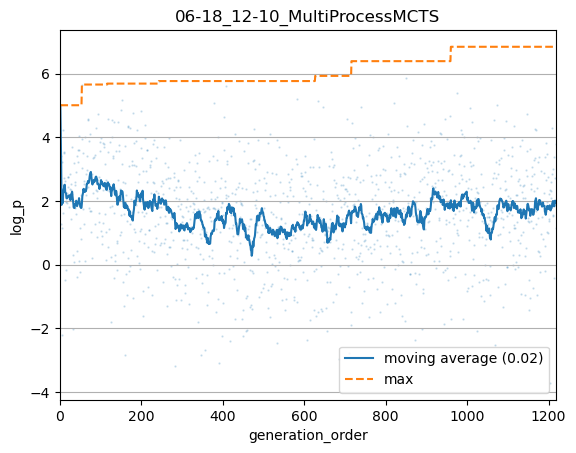

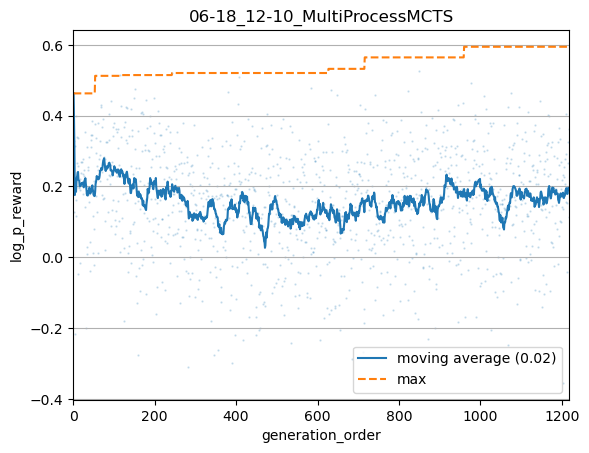

number of generated nodes: 1218
node_per_sec: 40.59190736938899


In [4]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
generator, conf = execute_yaml(c3)
# queue_yaml(c1, c2)

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [14]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
execute_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)